
This code uses the keras framework with the TensorFlow as the backend to run. Runtime errors will occur without these two

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Read the data and do a quick inspection
df = pd.read_csv("./data.csv")
print(df.info() , "\n")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 3 columns):
date               667 non-null int64
signal             667 non-null float64
spy_close_price    667 non-null float64
dtypes: float64(2), int64(1)
memory usage: 15.7 KB
None 

       date    signal  spy_close_price
0  20120103  3.107767          127.495
1  20120104  3.107282          127.700
2  20120105  3.099757          128.040
3  20120106  3.134223          127.710
4  20120109  3.135922          128.020


Before we can make any predictions with the signal, we need to make sure that the data is clean. The first step we took to clean the data was to identify whether there are any missing values in the data. 

In [96]:
#Check to see if there are any missing values
if df.isnull().values.any():
    print("There are missing values in data.csv\n")
    print(df.isnull().sum())
else:
    print("There are no missing values in data.csv\n")

There are no missing values in data.csv



From the code above, we see that there are no missing values in the data.

Since all values are susceptible to corruption, we have to do some checking and cleaning on each column.The stock market is only open on the weekdays, so there should not be any dates on the weekend. If there are any weekday entries, we will delete them as they do not belong. To check for this, we converted the date column to a datetime and used a built-in function to check to see if any dates were weekends. 

In [97]:
#Checked to see if there are any weekend entries
df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df["weekday"] = df["date"].dt.weekday
baddays = df.query("weekday > 4")
baddays

,date,signal,spy_close_price,weekday
525,2014-02-08,4.466505,179.68,5
526,2014-02-09,4.466505,179.68,6


We see that there are two entries that occur on weekend. The stock market should not open during those dates, so we are going to drop those indexes

In [98]:
#drop the bad rows
df = df.drop([525,526],axis=0)
#drop the weekday column that we added just before as it is not used in our prediction
df = df.drop(['weekday'],axis=1)
#the number of rows should now be 667-2, or 665
df.shape

(665, 3)

Next, we are going to plot the date Vs spy_close_price to get a sense of how the stock prices fluctuate over time.

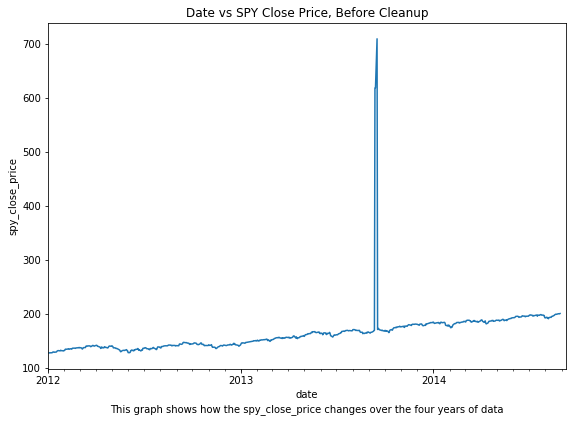

In [99]:
import datetime
import matplotlib.dates as mdates

years = mdates.YearLocator()   
months = mdates.MonthLocator() 
yearsFmt = mdates.DateFormatter('%Y')
monthsFmt = mdates.DateFormatter('%m')

caption = "This graph shows how the spy_close_price changes over the four years of data"
fig = plt.figure()
ax1 = fig.add_axes((0.5, 0.3, 1.2, 1.2))

ax1.set_title("Date vs SPY Close Price, Before Cleanup")
ax1.set_xlabel('date')
ax1.set_ylabel('spy_close_price')

ax1.plot(df['date'].values,df['spy_close_price'].values)
fig.text(1.1, 0.15, caption, ha='center')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(yearsFmt)
ax1.xaxis.set_minor_locator(months)
ax1.set_xlim([datetime.date(2012, 1, 1), datetime.date(2014, 9, 10)])
plt.show()

From this graph, we see that there are some outlier spy_close_price values. These outlier are most likely erroneous values that we want to fix. 

In [100]:
#Calculate the mean and std of the spy_close_price
spy_mean = df['spy_close_price'].mean()
spy_std = df['spy_close_price'].std()
print("spy_close_price mean: ", spy_mean)
print("spy_close_price std: ", spy_std)

def setBadSpyToNaN(val):
    if (val > spy_mean + 2*spy_std) or (val < spy_mean - 2*spy_std): 
        val = np.nan
    return val

#first set all values of spy_close_price that are more than two std away from mean to NaN
df["spy_close_price"] = df["spy_close_price"].apply(setBadSpyToNaN)
#use the interpolate method to fill in the NaN values
df["spy_close_price"] = df["spy_close_price"].interpolate()

spy_close_price mean:  163.1197127819548
spy_close_price std:  39.258904295140134


We began by calculating the mean and standard deviation of the spy_close_price column. We deemed any value that is more than two standard deviations from the mean, while neither the preceding nor the following row value is, to be an outlier. To clean up such a value, we first converted such values to NaN and replaced them using the interpolate function with the linear method.

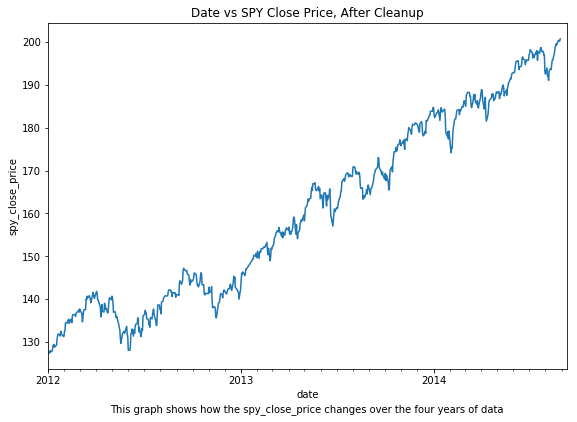

In [101]:
caption = "This graph shows how the spy_close_price changes over the four years of data"
fig = plt.figure()
ax1 = fig.add_axes((0.5, 0.3, 1.2, 1.2))

ax1.set_title("Date vs SPY Close Price, After Cleanup")
ax1.set_xlabel('date')
ax1.set_ylabel('spy_close_price')

ax1.plot(df['date'].values,df['spy_close_price'].values)
fig.text(1.1, 0.15, caption, ha='center')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(yearsFmt)
ax1.xaxis.set_minor_locator(months)
ax1.set_xlim([datetime.date(2012, 1, 1), datetime.date(2014, 9, 10)])
plt.show()

After we clean the spy_close_price, we are going to plot the date Vs spy_close_price one again. The graph is now a lot more smooth without the outlier values

We then plot the date vs signal to see how the similar the signal is to the spy_close_price.

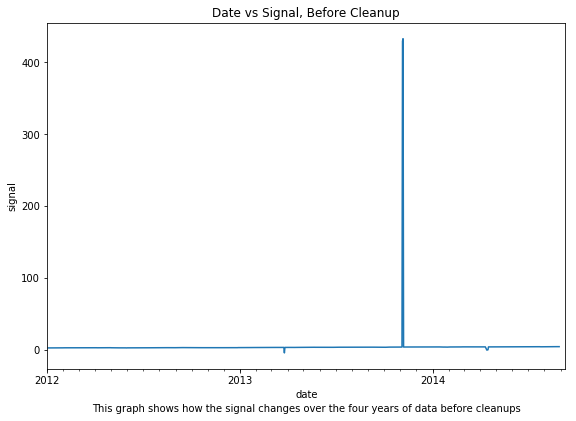

In [102]:
caption = "This graph shows how the signal changes over the four years of data before cleanups"
fig = plt.figure()
ax1 = fig.add_axes((0.5, 0.3, 1.2, 1.2))

ax1.set_title("Date vs Signal, Before Cleanup")
ax1.set_xlabel('date')
ax1.set_ylabel('signal')

ax1.plot(df['date'].values,df['signal'].values)
fig.text(1.1, 0.15, caption, ha='center')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(yearsFmt)
ax1.xaxis.set_minor_locator(months)
ax1.set_xlim([datetime.date(2012, 1, 1), datetime.date(2014, 9, 10)])
plt.show()

From the graph, we see that were are some are outlier values as there is a large spike in the part of the graph and a few values that are much lower than the average. 

In [103]:
#calculate the mean and std values for the signal column
signal_mean = df['signal'].mean()
signal_std = df['signal'].std()
print("signal mean: ", signal_mean)
print("signal std: ", signal_std)

#We are unable to use mean and std for this, used best judgement based on observing the data
def setBadSignalToNaN(val):
    if (val > 10) or (val < 2): 
        val = np.nan
    return val

#first set all the bad values to NaN
df["signal"] = df["signal"].apply(setBadSignalToNaN)
#use the interpolate method to fill in
df["signal"] = df["signal"].interpolate()

signal mean:  5.168708372412027
signal std:  23.427990039992558


We will clean up the signal values using the same methodolgy as we used for the spy_close_price. The only difference is that we determined the cutoff values for outliers by observing the given data since the standard deviation was too large to be used.

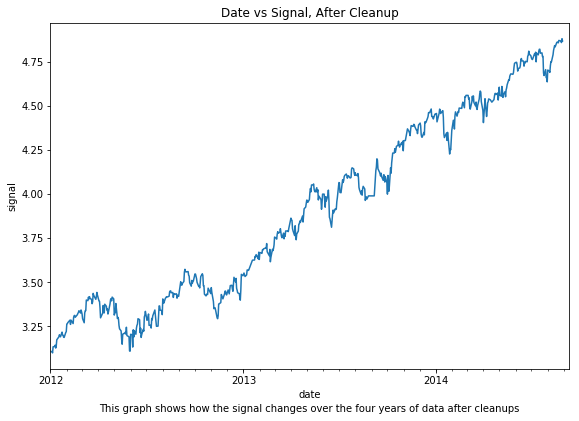

In [104]:
caption = "This graph shows how the signal changes over the four years of data after cleanups"
fig = plt.figure()
ax1 = fig.add_axes((0.5, 0.3, 1.2, 1.2))

ax1.set_title("Date vs Signal, After Cleanup")
ax1.set_xlabel('date')
ax1.set_ylabel('signal')

ax1.plot(df['date'].values,df['signal'].values)
fig.text(1.1, 0.15, caption, ha='center')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(yearsFmt)
ax1.xaxis.set_minor_locator(months)
ax1.set_xlim([datetime.date(2012, 1, 1), datetime.date(2014, 9, 10)])
plt.show()

After cleaning up the signal, we graphed it once more. Now we see that the two graphs look very similar, so we know that the data has been properly cleaned up. For my analysis, I decided to first do a simple regession to test the predictive abilties of the signal. Before I can do that, I need to normalize the data.

In [105]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

encoder = LabelEncoder()
df['date'] = encoder.fit_transform(df['date'])
df = df.astype('float32')
#normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

# use 75% of data to train, 25% to test
test_train_split = int(scaled.shape[0]*0.75)
train = scaled[:test_train_split, :]
test = scaled[test_train_split:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

To use the MinxMaxScaler to scale our data, we first need to convert the dates to numeric values. After normalizing the data, I split the data into two part. I used 75% of the data to train my regression model and used the remaining 25% of the data to test my model. I used the date and the signal as the input features and the spy_close_price is the target value.

I chose to use the RandomForestRegressor module as my model.

RMSE: 8.852
R-squared = : -1.071


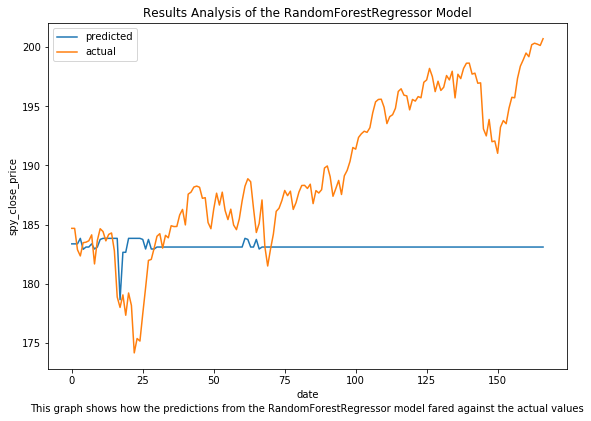

In [106]:
from sklearn.ensemble import RandomForestRegressor

#build the regessor model, fit it, and use it to make a prediction
regr = RandomForestRegressor()
regr.fit(train_X, train_y)
pred_y = regr.predict(test_X)
pred_y = pred_y.reshape(pred_y.shape[0],1)

# invert scaling for the prediction
pred = np.concatenate((test_X,pred_y), axis=1)
inv_pred = scaler.inverse_transform(pred)
inv_pred = inv_pred[:,-1]

# invert scaling for actual
test_y = test_y.reshape(test_y.shape[0],1)
actual = np.concatenate((test_X,test_y), axis=1)
inv_actual = scaler.inverse_transform(actual)
inv_actual = inv_actual[:,-1]

from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
rmse = sqrt(mean_squared_error(inv_actual, inv_pred))
print('RMSE: %.3f' % rmse)
r2_score = r2_score(inv_actual, inv_pred)
print('R-squared = : %.3f' % r2_score)

#plot the results
caption = "This graph shows how the predictions from the RandomForestRegressor model fared against the actual values"
fig = plt.figure()
ax1 = fig.add_axes((0.5, 0.3, 1.2, 1.2))

ax1.set_title('Results Analysis of the RandomForestRegressor Model')
ax1.set_xlabel('date')
ax1.set_ylabel('spy_close_price')

plt.plot(inv_pred, label='predicted')
plt.plot(inv_actual, label='actual')
plt.legend()
fig.text(1.1, 0.15, caption, ha='center')
plt.show()

After fitting the regeression model and making a prediction, I calcuated the RMSE, the R^2 value of the results, and graphed the predicted values vs the actual values. The RMSE value came out to be pretty small. However, the R^2 value turned out to be negative and the graph also shows that this model did not make good predictions. 

Seeing how bad the results were, I decided to not try to tune the model and chose to try a different approach. This time I am going to create a LSTM recurrent neural network using the Keras framework to do time series forecasting. Before I can do that, I need to first prepare my data and reframe the data as a supervised learning problem.

In [107]:
# Frame the sequence as a supervised learning problem
# Base code from Jason Brownlee of machinelearningmastery.com
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

reframed = series_to_supervised(scaled, 1, 1)
#drop the columns we dont want to predict 
reframed.drop(reframed.columns[[0,3,4]], axis=1, inplace=True)
reframed.columns = ['Signal(t-1)','Spy Close Price(t-1)','Spy Close Price(t)']
print(reframed.head())

   Signal(t-1)  Spy Close Price(t-1)  Spy Close Price(t)
1     0.004496              0.000000            0.002800
2     0.004223              0.002800            0.007444
3     0.000000              0.007444            0.002937
4     0.019346              0.002937            0.007171
5     0.020300              0.007171            0.022332


In this supervised learning problem, I will be using the signal and the spy_close_price values of the previous day (t-1) as input features to to calculate the spy_close_price of the current day (t). 

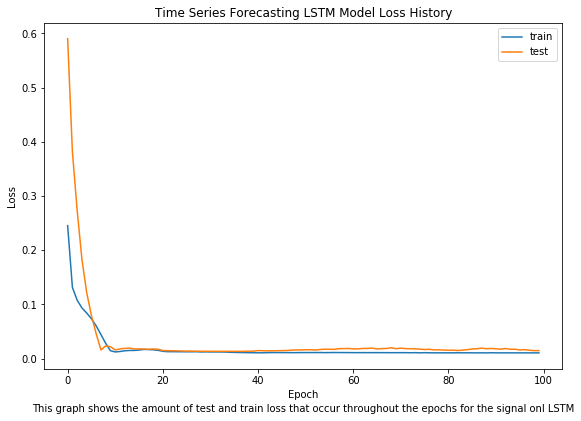

In [108]:
# Base code from Jason Brownlee of machinelearningmastery.com
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# split into train and test sets
values = reframed.values
# use 75% of data to train, 25% to test
test_train_split = int(values.shape[0]*0.75)
train = values[:test_train_split, :]
test = values[test_train_split:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# design network
model = Sequential()
#
model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
# higher epoch and lower batch size = better results, but speed

history = model.fit(train_X, train_y, epochs=100, batch_size=16, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
caption = "This graph shows the amount of test and train loss that occur throughout the epochs for the signal onl LSTM"
fig = plt.figure()
ax1 = fig.add_axes((0.5, 0.3, 1.2, 1.2))

ax1.set_title('Time Series Forecasting LSTM Model Loss History')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='test')
ax1.legend()
fig.text(1.1, 0.15, caption, ha='center')
plt.show()

# make a prediction
pred_y = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

After playing with the model parameters for a bit, I was able to create a model that did a pretty good job at using the previous day's data to predict the spy_close_price. From my experience, having more neurons on the first hidden layer and more epochs improved my results to an extent. Having more than 30 neurons and 100 epochs did not make any significant improvements to the model for this dataset. Smaller batch sizes also help improved my model. However, the model would be worse after a certain lower bound threshold of batch size.

The loss history graph also shows that the loss values became increasing low with each epochs. The low loss values are an indictor that this may be a good model.

RMSE: 1.401
R-squared = : 0.948


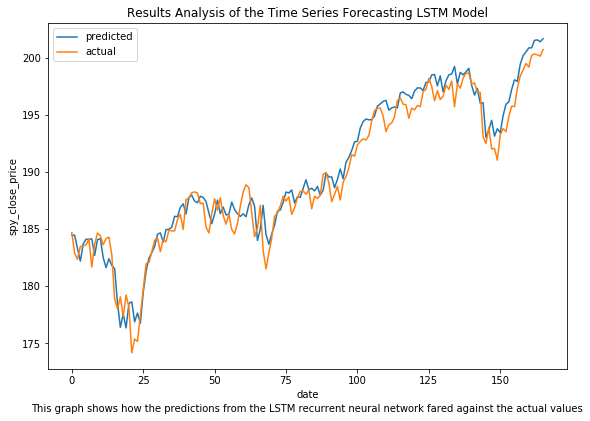

In [109]:
# Base code from Jason Brownlee of machinelearningmastery.com
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

test_dates = values[test_train_split:, 0]
test_dates = test_dates.reshape((len(test_y), 1))

# invert scaling for the predicted values
pred = np.concatenate((test_dates,test_X[:, :-1],pred_y), axis=1)
inv_pred = scaler.inverse_transform(pred)
inv_pred = inv_pred[:,-1]

# invert scaling for actual values
test_y = test_y.reshape((len(test_y), 1))
actual = np.concatenate((test_dates,test_X[:, :-1],test_y), axis=1)
inv_actual = scaler.inverse_transform(actual)
inv_actual = inv_actual[:,-1]

rmse = sqrt(mean_squared_error(inv_actual, inv_pred))
print('RMSE: %.3f' % rmse)

r2_score = r2_score(inv_actual, inv_pred)
print('R-squared = : %.3f' % r2_score)

#plot the results
caption = "This graph shows how the predictions from the LSTM recurrent neural network fared against the actual values"
fig = plt.figure()
ax1 = fig.add_axes((0.5, 0.3, 1.2, 1.2))

ax1.set_title('Results Analysis of the Time Series Forecasting LSTM Model')
ax1.set_xlabel('date')
ax1.set_ylabel('spy_close_price')

plt.plot(inv_pred, label='predicted')
plt.plot(inv_actual, label='actual')
plt.legend()
fig.text(1.1, 0.15, caption, ha='center')
plt.show()

The RMSE was faily low and the R^2 values was close to 1. The predicted model follow the same trend as the actual values. Based on all of these statistics, I conclude that this model is effective at predicting the spy_close_prices. 

Seeing how well the LSTM performed, I was curious how effective it would be to only the signal as the input feature. For the following model, I directly took the normalized data and applied LSTM onto it. The signal was the input feature and the output feature is spy_close_price. For easier comparison to the previous model, I chose to leave all of the other parameter the same.

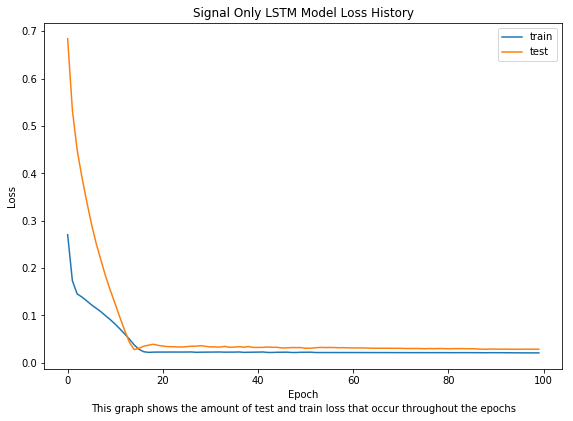

In [110]:
# use 75% of data to train, 25% to test
test_train_split = int(scaled.shape[0]*0.75)
train = scaled[:test_train_split,1:]
test = scaled[test_train_split:,1:]

# split into input and outputs
train_X, train_y = train[:, 0], train[:, -1]
test_X, test_y = test[:, 0], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, 1))
test_X = test_X.reshape((test_X.shape[0], 1, 1))

# design network
model = Sequential()
model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network

history = model.fit(train_X, train_y, epochs=100, batch_size=16, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
caption = "This graph shows the amount of test and train loss that occur throughout the epochs"
fig = plt.figure()
ax1 = fig.add_axes((0.5, 0.3, 1.2, 1.2))

ax1.set_title('Signal Only LSTM Model Loss History')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='test')
ax1.legend()
fig.text(1.1, 0.15, caption, ha='center')
plt.show()

# make a prediction
pred_y = model.predict(test_X)

Like the previous model, there seems to be very little loss in the test and train data. However, compared to the previous model, it took more epoches to get this low loss value. 

RMSE: 2.667
R-squared = : 0.812


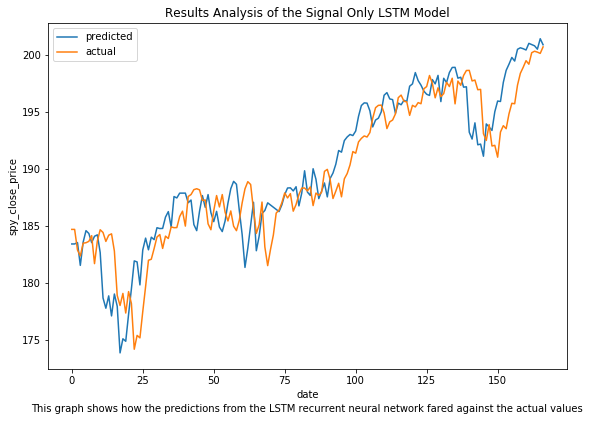

In [111]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_dates = scaled[test_train_split:, 0]
test_dates = test_dates.reshape((len(test_y), 1))
#test_X = test_X[:, 0].reshape((len(test_X), 1))

# invert scaling for the predicted values
pred = np.concatenate((test_dates,test_X,pred_y), axis=1)
inv_pred = scaler.inverse_transform(pred)
inv_pred = inv_pred[:,-1]

# invert scaling for actual values
test_y = test_y.reshape((len(test_y), 1))
actual = np.concatenate((test_dates,test_X,test_y), axis=1)
inv_actual = scaler.inverse_transform(actual)
inv_actual = inv_actual[:,-1]


from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
rmse = sqrt(mean_squared_error(inv_actual, inv_pred))
print('RMSE: %.3f' % rmse)

r2_score = r2_score(inv_actual, inv_pred)
print('R-squared = : %.3f' % r2_score)

#plot the results
caption = "This graph shows how the predictions from the LSTM recurrent neural network fared against the actual values"
fig = plt.figure()
ax1 = fig.add_axes((0.5, 0.3, 1.2, 1.2))

ax1.set_title('Results Analysis of the Signal Only LSTM Model')
ax1.set_xlabel('date')
ax1.set_ylabel('spy_close_price')

plt.plot(inv_pred, label='predicted')
plt.plot(inv_actual, label='actual')
plt.legend()
fig.text(1.1, 0.15, caption, ha='center')
plt.show()

Using just the signal as the input parameter results in a higher RSME and a lower R^2 score. However, the results are still fairly satisfactory. The graph also shows that the predicted values follow a similar trend to the acutal values as well.

If I had more time to improve my analysis, I would redo the models with stationary input data. According to my teammate Youri, the provided data is not stationary and stationary data may result in improved resulted. I could also try to provide more than one input step when creating my supervised learning problem. 

Additionally, I would play with the LSTM networks parameters more to get better results. In the future, I would consider adding more hidden layers and seeing how they affect my result.